In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import CategoricalDtype

import requests
from bs4 import BeautifulSoup

from datetime import date

In [11]:
#Скачивание ключевой ставки в df
URL = 'https://www.cbr.ru/hd_base/keyrate/?UniDbQuery.Posted=True&UniDbQuery.From=17.09.2013&UniDbQuery.To=' + date.today().strftime('%d.%m.%Y')

data = requests.get(URL).text

bs4 = BeautifulSoup(data, "html.parser")
table = bs4.find_all("table")

df = pd.read_html(str(table))[0]
df.iloc[:,1:] /= 100

In [12]:
#Преобразование столбца дата в формат datetime
df['Дата'] = pd.to_datetime(df['Дата'], dayfirst=True).dt.strftime('%d.%m.%Y')

#Перенаименование столбцов
df.columns = ['date', 'key_rate']
df['date'] = pd.to_datetime(df['date'], dayfirst=True)

In [13]:
#Общая информацию о датафрейме
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2611 entries, 0 to 2610
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      2611 non-null   datetime64[ns]
 1   key_rate  2611 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 40.9 KB


In [14]:
#Jсновные описательные статистики для числовых признаков
df.iloc[:, 1:].describe()

,key_rate
count,2611.000000
mean,8.641038
std,3.109981
min,4.250000
25%,7.000000
50%,7.750000
75%,10.000000
max,20.000000


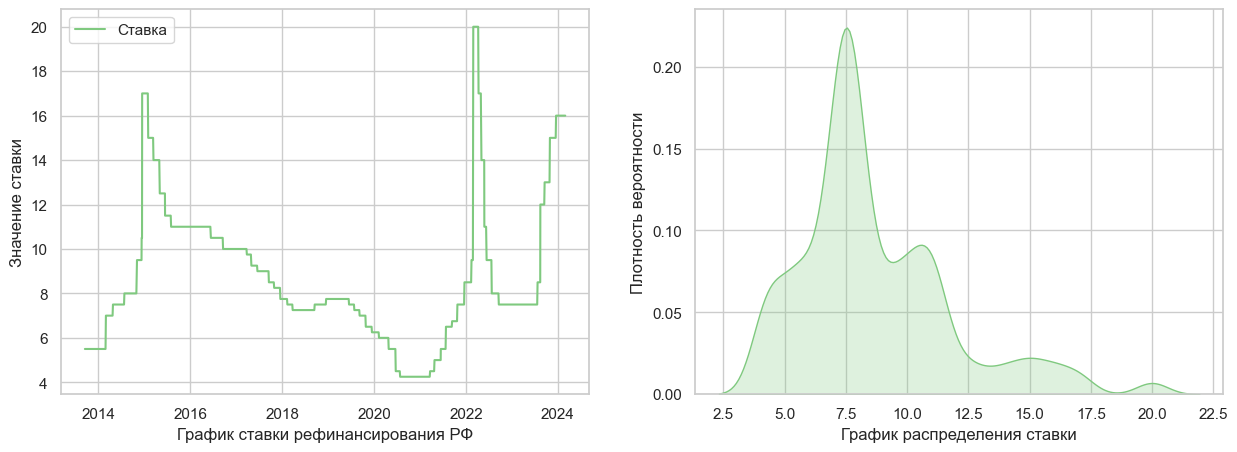

In [15]:
figure, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.set_theme(style="whitegrid", palette="Accent")

sns.lineplot(x='date', y='key_rate', data=df, label='Ставка', ax=axes[0])
axes[0].set_xlabel('График ставки рефинансирования РФ')
axes[0].set_ylabel('Значение ставки')
axes[0].legend(loc='best')
axes[0].grid(True)

sns.kdeplot(x=df['key_rate'], ax=axes[1], fill=True)
axes[1].grid(True)
axes[1].set_xlabel('График распределения ставки')
axes[1].set_ylabel('Плотность вероятности')
plt.show()

In [23]:
def create_features(data, col_datetime):
    """Создание сезонов"""

    data = data.copy()
    data['weekday'] = data[col_datetime].dt.day_name().astype(cat_day)
    data['month'] = data[col_datetime].dt.month
    data['year'] = data[col_datetime].dt.year
    data['quarter'] = data['date'].dt.quarter
    data['date_offset'] = (data[col_datetime].dt.month * 100 + data.date.dt.day - 320) % 1300
    data['season'] = pd.cut(data['date_offset'], [0, 300, 602, 900, 1300], labels=['Sping', 'Summer', 'Fall', 'Winter'])

    return data

cat_day = CategoricalDtype(categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered= True)

df_features = create_features(data=df, col_datetime='date')

In [24]:
df_features

,date,key_rate,weekday,month,year,quarter,date_offset,season
0,2024-02-29,16.0,Thursday,2,2024,1,1209,Winter
1,2024-02-28,16.0,Wednesday,2,2024,1,1208,Winter
2,2024-02-27,16.0,Tuesday,2,2024,1,1207,Winter
3,2024-02-26,16.0,Monday,2,2024,1,1206,Winter
4,2024-02-22,16.0,Thursday,2,2024,1,1202,Winter
...,...,...,...,...,...,...,...,...
2606,2013-09-23,5.5,Monday,9,2013,3,603,Fall
2607,2013-09-20,5.5,Friday,9,2013,3,600,Summer
2608,2013-09-19,5.5,Thursday,9,2013,3,599,Summer
2609,2013-09-18,5.5,Wednesday,9,2013,3,598,Summer
